# Classification of Standard Articles

The aim is to classify whether Standard Articles report an attack on the judiciary.

## Preparation

In [ ]:
!pip install pyreadr
!pip install torch
!pip install accelerate
!pip install tensorflow
!pip install datasets
!pip install transformers

# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.14.0
Eager mode:  True
Hub version:  0.15.0
GPU is available


In [3]:
import pyreadr
import re
import pandas as pd

imported = pyreadr.read_r('/content/articles_paragraphs_judiciary_annotated.rds')

paragraphs_handcoded = imported[None]
paragraphs_handcoded['article'] = paragraphs_handcoded['article'].astype(str)

df_labelled = paragraphs_handcoded.dropna(subset=['coded'])
df_unlabelled = paragraphs_handcoded[paragraphs_handcoded['coded'].isnull()]

n = len(df_labelled) / 5

df_train = df_labelled.sample(n = round(n * 3),
                              random_state = 1)
# anti-join for df_test
df_nontrain = df_labelled.merge(df_train, how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
df_val = df_nontrain.sample(n = round(n),
                              random_state = 1)
df_test = df_nontrain.merge(df_val, how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])


len(df_test) + len(df_train) + len(df_val) == len(df_labelled)

True

In [4]:
type(df_test)

pandas.core.frame.DataFrame

In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

## BERT

In [6]:
model_name = 'bert-base-cased'
BERT_tokenizer = AutoTokenizer.from_pretrained(model_name,
                                               model_max_length = 256) # by default, BERT takes inputs up to 512, but that will take a very long time to train, can't go over 512 but under

In [7]:
X_train = BERT_tokenizer(list(df_train['article']), padding='max_length', truncation=True, return_tensors='tf')
X_test = BERT_tokenizer(list(df_test['article']), padding='max_length', truncation=True, return_tensors='tf')
X_val = BERT_tokenizer(list(df_val['article']), padding='max_length', truncation=True, return_tensors='tf')

y_train = tf.convert_to_tensor(df_train['coded'])
y_test = tf.convert_to_tensor(df_test['coded'])
y_val = tf.convert_to_tensor(df_val['coded'])

In [8]:
# download pretrained model as TF, specify that there is one label in output layer
BERT_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 1)

BERT_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 108311041 (413.17 MB)
Trainable params: 108311041 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
BERT_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), #still adam optimizer, but we want to specify a small initial learning rate, because transformers like lower learning rates
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
history = BERT_model.fit(dict(X_train), y_train,
                         validation_data=(dict(X_val), y_val),
                         epochs = 10,
                         batch_size = 16)

Epoch 1/10
22/22 [==============================] - 69s 1s/step - loss: 0.5449 - accuracy: 0.7679 - val_loss: 0.6013 - val_accuracy: 0.7155
Epoch 2/10
22/22 [==============================] - 21s 948ms/step - loss: 0.5377 - accuracy: 0.7679 - val_loss: 0.5190 - val_accuracy: 0.7155
Epoch 3/10
22/22 [==============================] - 21s 943ms/step - loss: 0.3999 - accuracy: 0.7765 - val_loss: 0.4359 - val_accuracy: 0.7155
Epoch 4/10
22/22 [==============================] - 21s 960ms/step - loss: 0.3224 - accuracy: 0.7908 - val_loss: 0.4301 - val_accuracy: 0.8190
Epoch 5/10
22/22 [==============================] - 21s 979ms/step - loss: 0.3318 - accuracy: 0.8223 - val_loss: 0.4004 - val_accuracy: 0.8448
Epoch 6/10
22/22 [==============================] - 21s 969ms/step - loss: 0.2845 - accuracy: 0.8682 - val_loss: 0.3716 - val_accuracy: 0.7759
Epoch 7/10
22/22 [==============================] - 21s 949ms/step - loss: 0.3055 - accuracy: 0.8281 - val_loss: 0.4435 - val_accuracy: 0.8017
Ep

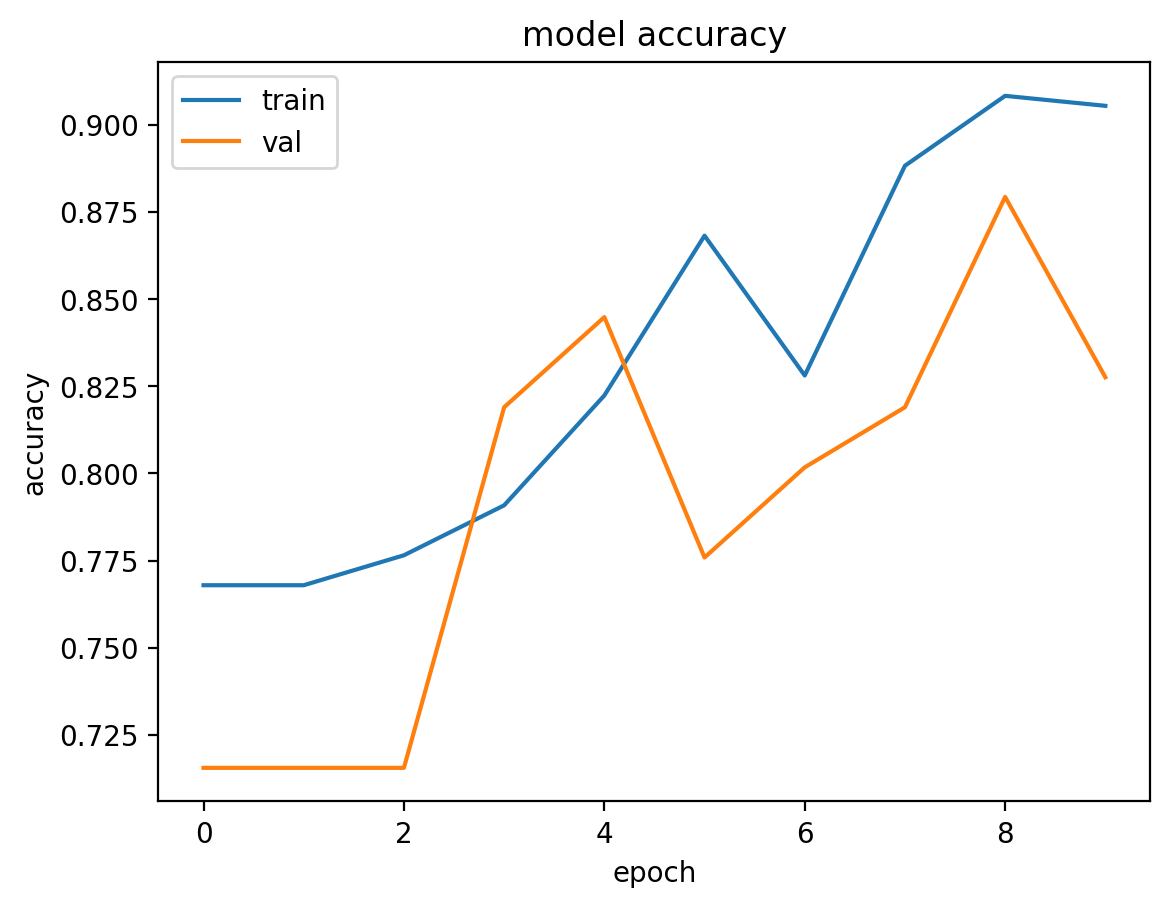

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

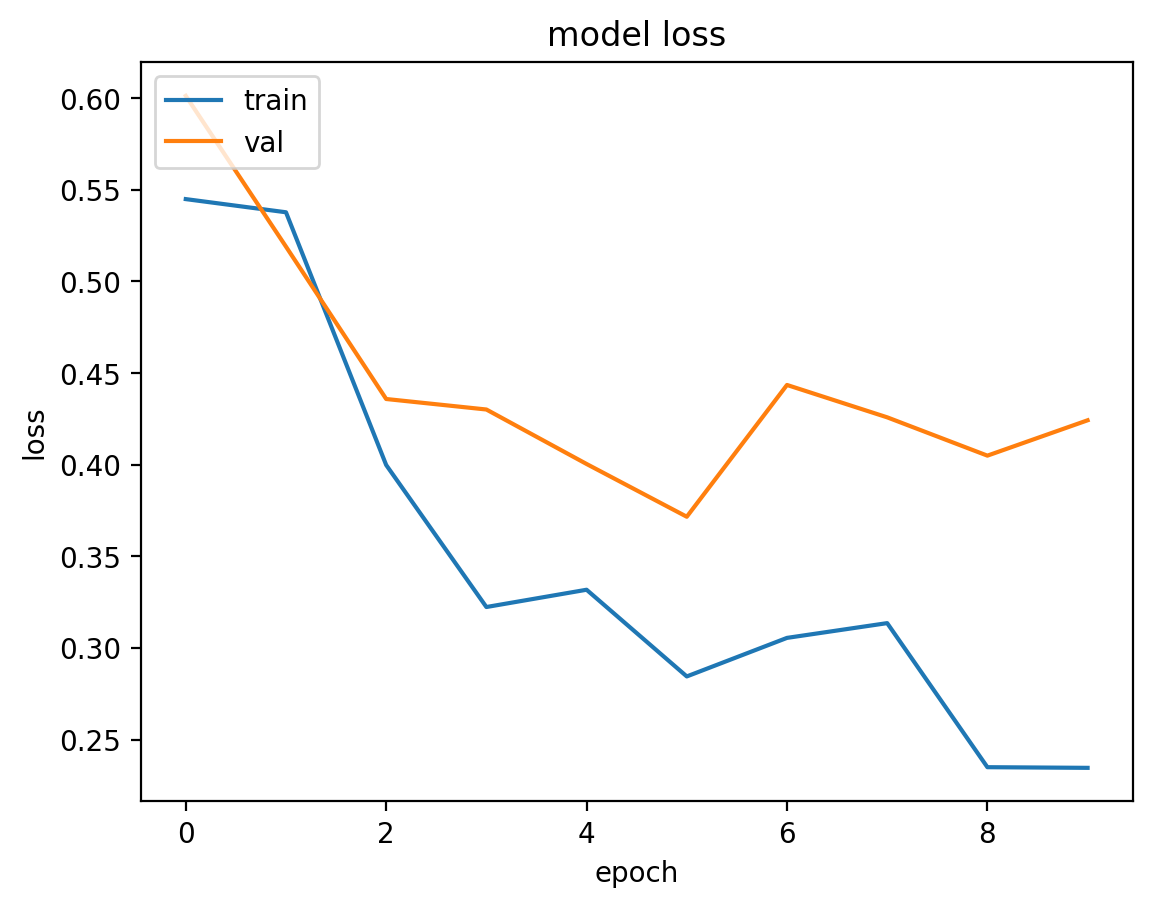

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
BERT_model.evaluate(dict(X_test), y_test, batch_size=100)

2/2 [==============================] - 2s 323ms/step - loss: 0.3235 - accuracy: 0.8547


[0.3234963119029999, 0.8547008633613586]

In [14]:
tf.keras.models.save_model()

True

## German BERT


In [16]:
model_name = 'bert-base-german-cased'
BERT_tokenizer = AutoTokenizer.from_pretrained(model_name,
                                               model_max_length = 256) # by default, BERT takes inputs up to 512, but that will take a very long time to train, can't go over 512 but under

In [17]:
X_train = BERT_tokenizer(list(df_train['article']), padding='max_length', truncation=True, return_tensors='tf')
X_test = BERT_tokenizer(list(df_test['article']), padding='max_length', truncation=True, return_tensors='tf')
X_val = BERT_tokenizer(list(df_val['article']), padding='max_length', truncation=True, return_tensors='tf')

y_train = tf.convert_to_tensor(df_train['coded'])
y_test = tf.convert_to_tensor(df_test['coded'])
y_val = tf.convert_to_tensor(df_val['coded'])

In [18]:
# download pretrained model as TF, specify that there is one label in output layer
BERT_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 1)

BERT_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109082113 (416.12 MB)
Trainable params: 109082113 (416.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
BERT_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), #still adam optimizer, but we want to specify a small initial learning rate, because transformers like lower learning rates
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
history = BERT_model.fit(dict(X_train), y_train,
                         validation_data=(dict(X_val), y_val),
                         epochs = 10,
                         batch_size = 16)

Epoch 1/10
22/22 [==============================] - 64s 1s/step - loss: 0.5246 - accuracy: 0.7679 - val_loss: 0.4306 - val_accuracy: 0.7155
Epoch 2/10
22/22 [==============================] - 21s 971ms/step - loss: 0.2574 - accuracy: 0.8911 - val_loss: 0.3775 - val_accuracy: 0.8707
Epoch 3/10
22/22 [==============================] - 21s 964ms/step - loss: 0.1141 - accuracy: 0.9599 - val_loss: 0.5366 - val_accuracy: 0.8190
Epoch 4/10
22/22 [==============================] - 21s 953ms/step - loss: 0.0563 - accuracy: 0.9771 - val_loss: 0.4234 - val_accuracy: 0.8793
Epoch 5/10
22/22 [==============================] - 21s 958ms/step - loss: 0.0358 - accuracy: 0.9914 - val_loss: 0.4709 - val_accuracy: 0.8534
Epoch 6/10
22/22 [==============================] - 21s 944ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.8601 - val_accuracy: 0.8103
Epoch 7/10
22/22 [==============================] - 21s 945ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.7622 - val_accuracy: 0.8448
Ep

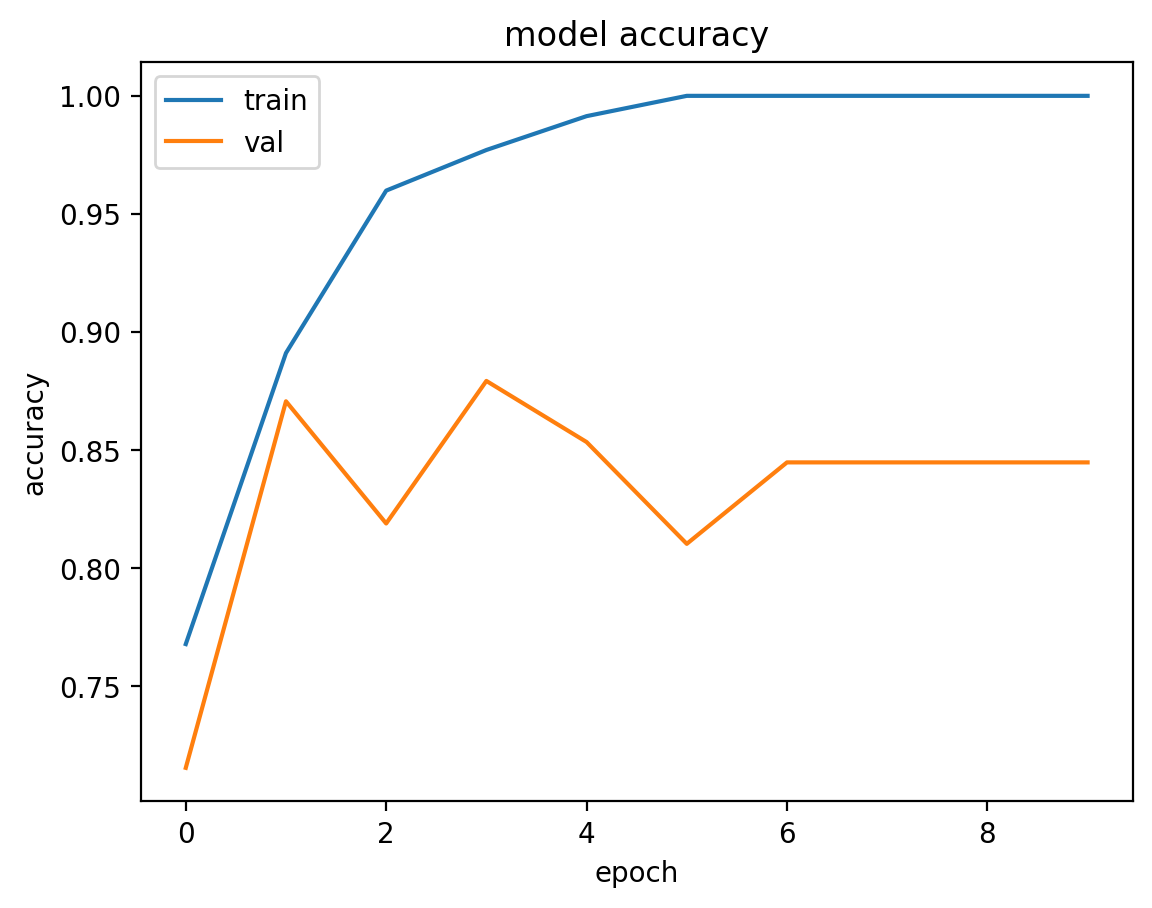

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

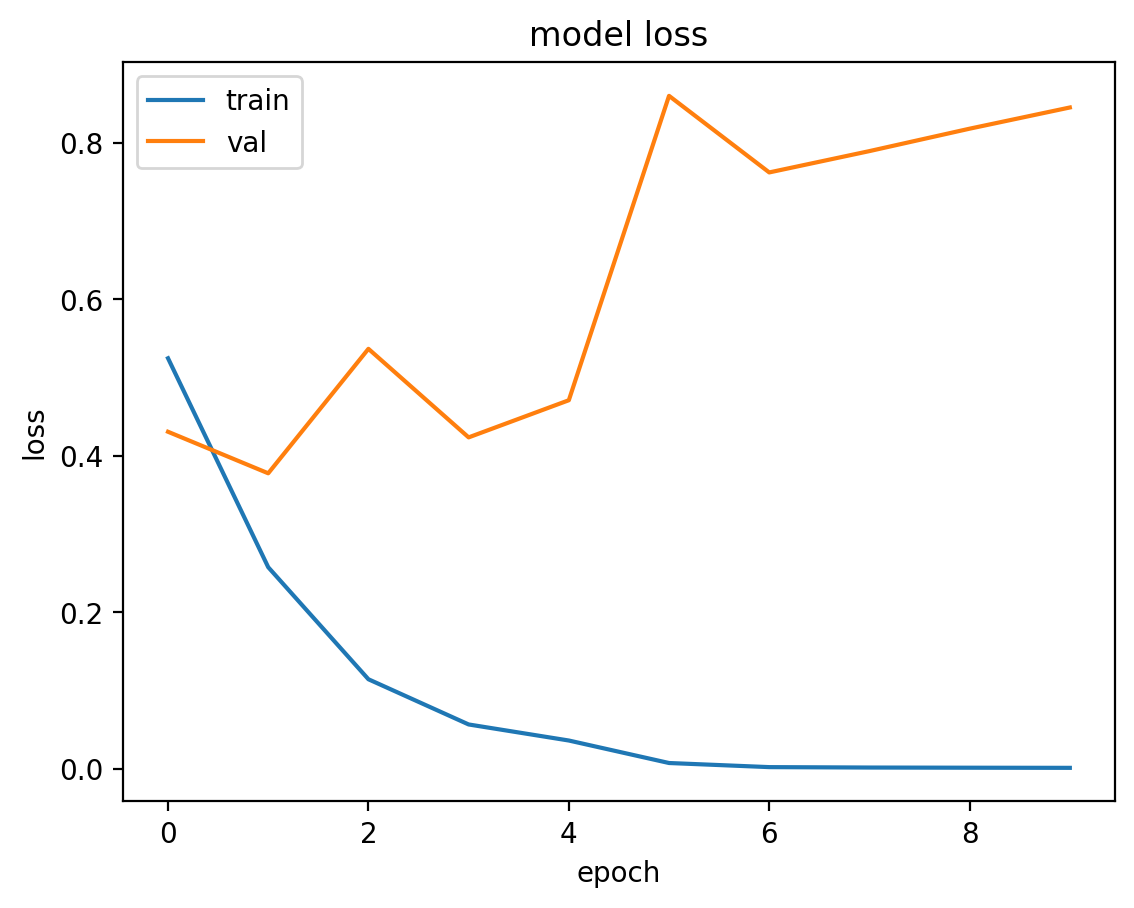

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
BERT_model.evaluate(dict(X_test), y_test, batch_size=100)

2/2 [==============================] - 2s 327ms/step - loss: 0.5230 - accuracy: 0.9060


[0.5229554176330566, 0.9059829115867615]

In [24]:
BERT_model.trainable

True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(BERT_model.layers))

Number of layers in the base model:  3


## DistilBERT




In [26]:
model_name = 'distilbert-base-uncased'
DBERT_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length = 512)

In [27]:
X_train = DBERT_tokenizer(list(df_train['article']), padding='max_length', truncation=True, return_tensors='tf')
X_test = DBERT_tokenizer(list(df_test['article']), padding='max_length', truncation=True, return_tensors='tf')
X_val = DBERT_tokenizer(list(df_val['article']),padding='max_length', truncation=True, return_tensors='tf')

y_train = tf.convert_to_tensor(df_train['coded'])
y_test = tf.convert_to_tensor(df_test['coded'])
y_val = tf.convert_to_tensor(df_val['coded'])

In [28]:
DBERT_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 1)

DBERT_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_95 (Dropout)        multiple                  0         
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
DBERT_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
history = DBERT_model.fit(dict(X_train), y_train,
                         validation_data=(dict(X_val), y_val),
                         epochs = 10,
                         batch_size = 16)

Epoch 1/10
22/22 [==============================] - 22s 1s/step - loss: 0.5363 - accuracy: 0.7679 - val_loss: 0.5592 - val_accuracy: 0.7155
Epoch 2/10
22/22 [==============================] - 22s 1s/step - loss: 0.4660 - accuracy: 0.7679 - val_loss: 0.4524 - val_accuracy: 0.7328
Epoch 3/10
22/22 [==============================] - 21s 980ms/step - loss: 0.2975 - accuracy: 0.8768 - val_loss: 1.1285 - val_accuracy: 0.4569
Epoch 4/10
22/22 [==============================] - 22s 983ms/step - loss: 0.4718 - accuracy: 0.7450 - val_loss: 0.5122 - val_accuracy: 0.7155
Epoch 5/10
22/22 [==============================] - 22s 1s/step - loss: 0.2830 - accuracy: 0.8138 - val_loss: 0.3465 - val_accuracy: 0.8879
Epoch 6/10
22/22 [==============================] - 22s 992ms/step - loss: 0.2043 - accuracy: 0.9284 - val_loss: 0.5395 - val_accuracy: 0.8190
Epoch 7/10
22/22 [==============================] - 22s 1s/step - loss: 0.1559 - accuracy: 0.9542 - val_loss: 0.3364 - val_accuracy: 0.8793
Epoch 8/10


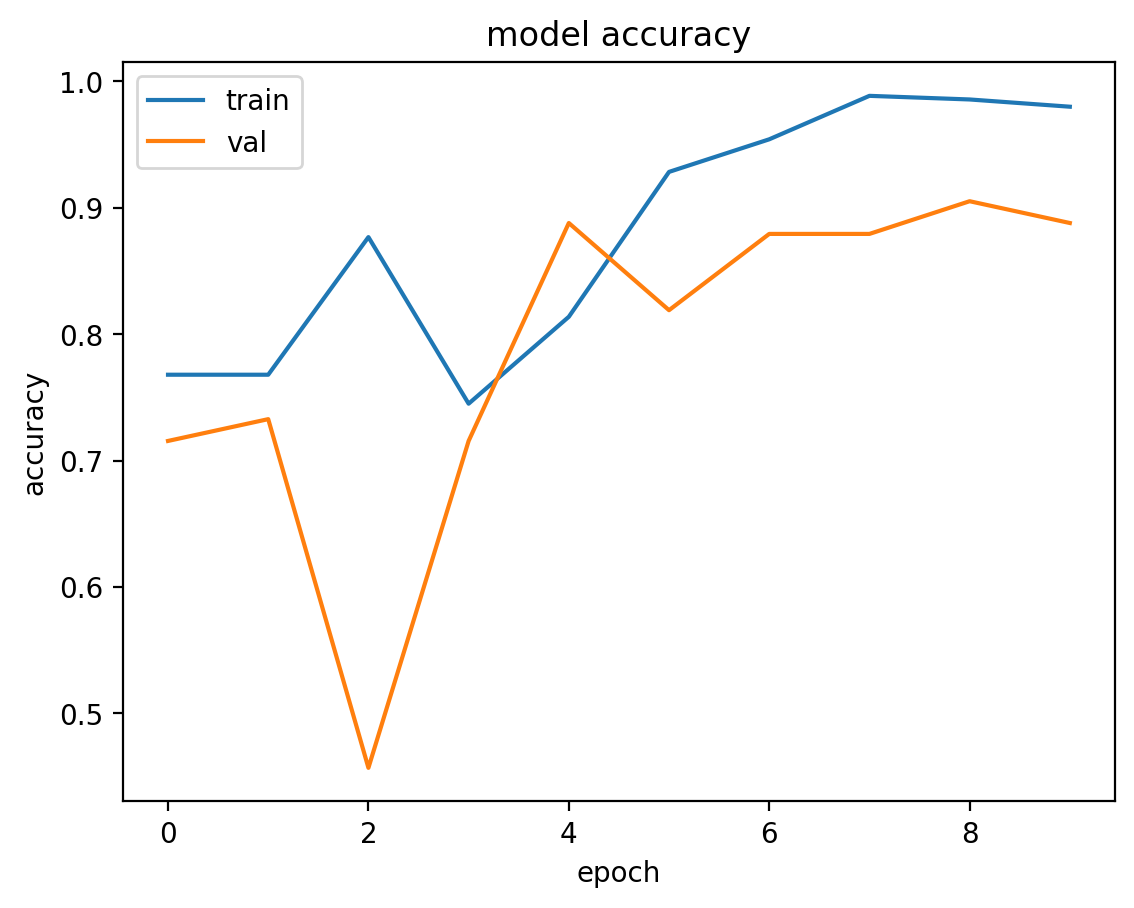

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

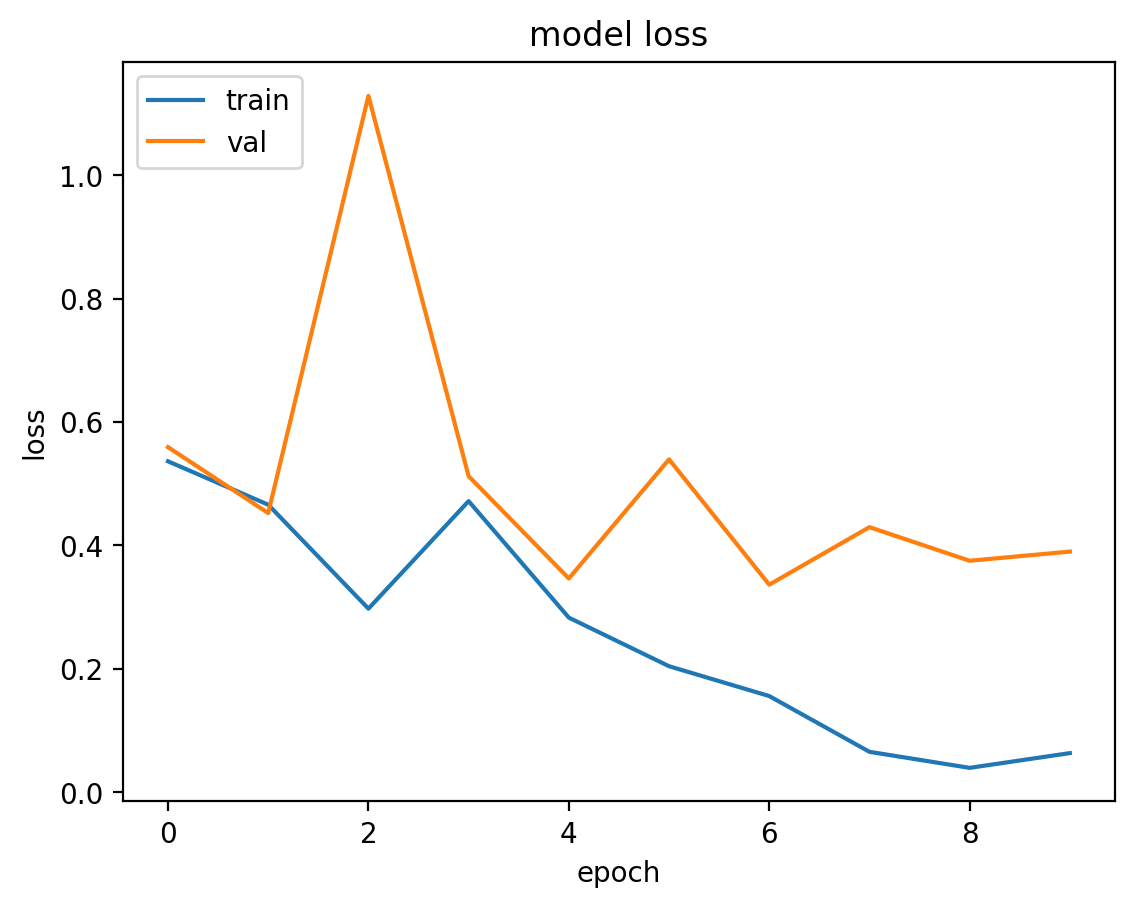

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
DBERT_model.evaluate(dict(X_test), y_test, batch_size = 100)

2/2 [==============================] - 2s 338ms/step - loss: 0.5776 - accuracy: 0.8291


[0.5776197910308838, 0.8290598392486572]